# Part 1

In [4]:
import os
import json
import glob
import pickle
import time
import cv2
import gym
import minerl
import torch
import torch as th
import numpy as np
from tqdm.auto import tqdm
# import faiss

from openai_vpt.agent import PI_HEAD_KWARGS, MineRLAgent
from openai_vpt.lib.policy import MinecraftPolicy
from data_loader import DataLoader
from openai_vpt.lib.tree_util import tree_map

ModuleNotFoundError: No module named 'faiss'

In [4]:
len(glob.glob("data/MakeWaterfallTrain/*.mp4"))

1001

In [ ]:
USING_FULL_DATASET = False

EPOCHS = 1 if USING_FULL_DATASET else 1
# Needs to be <= number of videos
BATCH_SIZE = 64 if USING_FULL_DATASET else 16
# Ideally more than batch size to create
# variation in datasets (otherwise, you will
# get a bunch of consecutive samples)
# Decrease this (and batch_size) if you run out of memory
N_WORKERS = 100 if USING_FULL_DATASET else 16
DEVICE = "cuda"

LOSS_REPORT_RATE = 100

# Tuned with bit of trial and error
LEARNING_RATE = 0.000181
# OpenAI VPT BC weight decay
# WEIGHT_DECAY = 0.039428
WEIGHT_DECAY = 0.0
# KL loss to the original model was not used in OpenAI VPT
KL_LOSS_WEIGHT = 1.0
MAX_GRAD_NORM = 5.0

MAX_BATCHES = 2000 if USING_FULL_DATASET else int(1e9)

In [2]:
def load_model_parameters(path_to_model_file):
    agent_parameters = pickle.load(open(path_to_model_file, "rb"))
    policy_kwargs = agent_parameters["model"]["args"]["net"]["args"]
    pi_head_kwargs = agent_parameters["model"]["args"]["pi_head_opts"]
    pi_head_kwargs["temperature"] = float(pi_head_kwargs["temperature"])
    return policy_kwargs, pi_head_kwargs

In [3]:
in_model = "data/VPT-models/foundation-model-1x.model"
in_weights = "data/VPT-models/foundation-model-1x.weights"

In [4]:
policy_kwargs, pi_head_kwargs = load_model_parameters(in_model)

In [5]:
agent_policy_kwargs, agent_pi_head_kwargs = load_model_parameters(in_model)

agent = MineRLAgent(device=DEVICE, policy_kwargs=agent_policy_kwargs, pi_head_kwargs=agent_pi_head_kwargs)

NameError: name 'MineRLAgent' is not defined

In [16]:
agent.policy.pi_head

DictActionHead(
  (camera): CategoricalActionHead(
    (linear_layer): Linear(in_features=1024, out_features=121, bias=True)
  )
  (buttons): CategoricalActionHead(
    (linear_layer): Linear(in_features=1024, out_features=8641, bias=True)
  )
)

In [8]:
from openai_vpt.lib.action_mapping import CameraHierarchicalMapping
from openai_vpt.lib.actions import ActionTransformer

In [9]:
ACTION_TRANSFORMER_KWARGS = dict(
    camera_binsize=2,
    camera_maxval=10,
    camera_mu=10,
    camera_quantization_scheme="mu_law",
)
action_mapper = CameraHierarchicalMapping(n_camera_bins=11)
action_transformer = ActionTransformer(**ACTION_TRANSFORMER_KWARGS)

In [ ]:
def env_action_to_agent(minerl_action_transformed, to_torch=False, check_if_null=False):
    """
    Turn action from MineRL to model's action.

    Note that this will add batch dimensions to the action.
    Returns numpy arrays, unless `to_torch` is True, in which case it returns torch tensors.

    If `check_if_null` is True, check if the action is null (no action) after the initial
    transformation. This matches the behaviour done in OpenAI's VPT work.
    If action is null, return "None" instead
    """
    minerl_action = action_transformer.env2policy(minerl_action_transformed)
    if check_if_null:
        if np.all(minerl_action["buttons"] == 0) and np.all(minerl_action["camera"] == action_transformer.camera_zero_bin):
            return None

    # Add batch dims if not existant
    if minerl_action["camera"].ndim == 1:
        minerl_action = {k: v[None] for k, v in minerl_action.items()}
    action = action_mapper.from_factored(minerl_action)
    if to_torch:
        action = {k: th.from_numpy(v).to(DEVICE) for k, v in action.items()}
    return action

In [4]:
video_path = "data/MakeWaterfall/Player571-f153ac423f61-20220707-110239.mp4"

In [5]:
def load_frames(video_path):
    frames = []
    cap = cv2.VideoCapture(video_path)
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, (128, 128), interpolation=cv2.INTER_LINEAR)
        frames.append(frame)
    cap.release()
    return frames

In [6]:
def load_jsonl(jsonl_path):
    with open(jsonl_path) as f:
        return [json.loads(line) for line in f]

In [7]:
video = load_frames(video_path)

In [8]:
len(video)

1115

In [9]:
len(load_jsonl("data/MakeWaterfall/Player571-f153ac423f61-20220707-110239.jsonl"))

1114

In [11]:
def display_video(frames):
    for frame in frames:
        cv2.imshow("image", frame)
        cv2.waitKey(0)
    cv2.destroyAllWindows()

In [12]:
unique_ids = glob.glob(os.path.join('data/MakeWaterfall/', "*.mp4"))
unique_ids = list(set([os.path.basename(x).split(".")[0] for x in unique_ids]))

In [13]:
dummy_first = th.from_numpy(np.array((False,))).to(DEVICE).unsqueeze(1)

In [14]:
class VPTModel():
    '''VPT Model for Embedding Situations and Single Observations'''

    def __init__(self, model_path, weights_path=None, freeze=True, device='auto'):

        agent_policy_kwargs = self.load_model_parameters(model_path)
        self.policy = MinecraftPolicy(
            **agent_policy_kwargs, single_output=True)

        if device == 'auto':
            self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        else:
            self.device = device
        self.policy.to(self.device)

        if weights_path is not None:
            self.policy.load_state_dict(torch.load(
                weights_path, map_location=self.device))

        if freeze:
            for param in self.policy.parameters():
                param.requires_grad = False

        self.dummy_first = torch.from_numpy(np.array((False,))).to(self.device).unsqueeze(1)

    def load_model_parameters(self, model_path):
        '''Load model parameters from model_path'''

        with open(model_path, 'rb') as f:
            agent_parameters = pickle.load(f)
            policy_kwargs = agent_parameters["model"]["args"]["net"]["args"]

            return policy_kwargs

    def preprocess_obs(self, obs_frame):
        '''Turn observation from MineRL environment into model's observation'''
        policy_input = cv2.resize(
            obs_frame, (128, 128), interpolation=cv2.INTER_LINEAR)[None]
        policy_input = {"img": torch.from_numpy(policy_input).to(self.device)}
        return policy_input
    
    def encode(self, obs, state_in):
        '''Encode observation into latent space'''

        obs = self.preprocess_obs(obs)
        obs = tree_map(lambda x: x.unsqueeze(1), obs)
        latent_vec, state_out = self.policy(obs, state_in, context={"first": self.dummy_first})
        
        return latent_vec, state_out
    
    def encode_trajectory(self, trajectory):
        '''Encode expert trajectory frames into a latent vector with state history'''

        with torch.inference_mode():
            initial_state = self.policy.initial_state(1)
            hidden_state = initial_state
            latent_vectors = []

            for obs in tqdm(trajectory):
                latent, state_out = self.encode(obs, hidden_state)
                hidden_state = state_out
                latent_vectors.append(latent.squeeze().detach().cpu().numpy())

            return latent_vectors

In [15]:
class SituationsLoader():
    '''Load the data from the MakeWaterfall dataset and create situations'''
    def __init__(self, data_dir='data/MakeWaterfall/'):
        unique_ids = glob.glob(os.path.join(data_dir, "*.mp4"))
        unique_ids = list(set([os.path.basename(x).split(".")[0] for x in unique_ids]))[:1]

        self.demonstration_tuples = []
        for unique_id in unique_ids:
            video_path = os.path.abspath(os.path.join(data_dir, unique_id + ".mp4"))
            json_path = os.path.abspath(os.path.join(data_dir, unique_id + ".jsonl"))
            self.demonstration_tuples.append((unique_id, video_path, json_path))
    
    def __len__(self):
        return len(self.demonstration_tuples)
    
    def _load_video(self, video_path):
        frames = []
        cap = cv2.VideoCapture(video_path)
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.resize(frame, (128, 128), interpolation=cv2.INTER_LINEAR)
            frames.append(frame)
        cap.release()
        return frames
    
    def _load_jsonl(self, jsonl_path):
        with open(jsonl_path) as f:
            return [json.loads(line) for line in f]
        
    def build_situations(self, window_size=128, stride=2):
        
        situations = []
        for unique_id, video_path, json_path in tqdm(self.demonstration_tuples):
            video = self._load_video(video_path)
            jsonl = self._load_jsonl(json_path)
            
            for i in range(window_size, len(video) - window_size, stride):
                situation = {}
                situation['demo_id'] = unique_id
                situation['situation_idx'] = i
                situation['situation_obs'] = video[i-window_size:i+1] # 128 context + 1 current
                situations.append(situation)
                
        return situations
    
    def load_demonstrations(self):
        demonstrations = []
        for unique_id, video_path, json_path in tqdm(self.demonstration_tuples):
            video = self._load_video(video_path)
            jsonl = self._load_jsonl(json_path)
            demonstrations.append({
                'demo_id': unique_id,
                'video': video,
                'jsonl': jsonl

            })
        return demonstrations
    
    def save_situations(self, situations, save_path):
        with open(save_path, 'wb') as f:
            pickle.dump(situations, f)

    def load_situations(self, save_path):
        with open(save_path, 'rb') as f:
            return pickle.load(f)

In [24]:
class SituationsLoader2():
    '''Complete External Memory System for REBECA'''

    def __init__(self, model_path, weights_path=None, freeze=True, device='auto'):
        self.vpt = VPTModel(model_path, weights_path, freeze, device)

    def load_expert_data(self, data_dir='data/MakeWaterfall/'):
        '''Load expert demonstrations from data_dir'''

        unique_ids = glob.glob(os.path.join(data_dir, "*.mp4"))
        unique_ids = list(
            set([os.path.basename(x).split(".")[0] for x in unique_ids]))[:1]

        self.demonstration_tuples = []
        for unique_id in unique_ids:
            video_path = os.path.abspath(
                os.path.join(data_dir, unique_id + ".mp4"))
            json_path = os.path.abspath(
                os.path.join(data_dir, unique_id + ".jsonl"))
            self.demonstration_tuples.append(
                (unique_id, video_path, json_path))
            
    def load_demonstrations(self):
        demonstrations = []
        for unique_id, video_path, json_path in tqdm(self.demonstration_tuples):
            video = self._load_video(video_path)
            jsonl = self._load_jsonl(json_path)
            demonstrations.append({
                'demo_id': unique_id,
                'video': video,
                'jsonl': jsonl

            })
        return demonstrations
    
    def encode_demonstrations(self, demonstrations):
        encoded_demos = []
        for demo in tqdm(demonstrations):
            encoded_demo = self.vpt.encode_trajectory(demo['video'])
            encoded_demos.append({
                'demo_id': demo['demo_id'],
                'encoded_demo': encoded_demo
            })
        return encoded_demos
    
    def create_situations(self, encoded_demos, window_size=128, stride=2):
        situations = []
        for demo in tqdm(encoded_demos):
            for i in range(window_size, len(demo['encoded_demo']) - window_size, stride):
                situations.append({
                    'demo_id': demo['demo_id'],
                    'situation_idx': i,
                    'situation': demo['encoded_demo'][i]
                })
        return situations

    def _load_video(self, video_path):
        frames = []
        cap = cv2.VideoCapture(video_path)
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.resize(frame, (128, 128),
                               interpolation=cv2.INTER_LINEAR)
            frames.append(frame)
        cap.release()
        return frames

    def _load_jsonl(self, jsonl_path):
        with open(jsonl_path) as f:
            return [json.loads(line) for line in f]

    def save_situations(self, situations, save_path):
        with open(save_path, 'wb') as f:
            pickle.dump(situations, f)

    def load_situations(self, save_path):
        with open(save_path, 'rb') as f:
            return pickle.load(f)

In [25]:
situation_loader = SituationsLoader()
memory = Memory(in_model)

In [26]:
memory.load_expert_data()

In [27]:
demonstrations = memory.load_demonstrations()

  0%|          | 0/1 [00:00<?, ?it/s]

In [28]:
encoded_demos = memory.encode_demonstrations(demonstrations)
mem_situations = memory.create_situations(encoded_demos)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1029 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [29]:
len(mem_situations)

387

In [19]:
situations = situation_loader.build_situations()

  0%|          | 0/1 [00:00<?, ?it/s]

In [20]:
len(situations), len(situations) * 129

(387, 49923)

In [21]:
demonstrations = situation_loader.load_demonstrations()

  0%|          | 0/1 [00:00<?, ?it/s]

In [22]:
sum([len(demo['video']) for demo in demonstrations])

953

In [31]:
situation_latents = []

with th.inference_mode():
    for situation in tqdm(situations[:3]):
        situation_obs = situation['situation_obs']

        initial_state = memory.vpt.policy.initial_state(1)
        states = [initial_state]

        for obs in situation_obs:
            obs = memory.vpt.preprocess_obs(obs)
            obs = tree_map(lambda x: x.unsqueeze(1), obs)
            pi_latent, state_out = memory.vpt.policy(obs, states[-1], context={"first": dummy_first})
            states.append(state_out)
        
        situation_latents.append({
            'demo_id': situation['demo_id'],
            'situation_idx': situation['situation_idx'],
            'situation_latent': pi_latent.squeeze().detach().cpu().numpy()
        })

  0%|          | 0/3 [00:00<?, ?it/s]

In [33]:
situation_latents[0]

{'demo_id': 'Player757-db89409b658a-20220705-000459',
 'situation_idx': 128,
 'situation_latent': array([ 0.7239679, -0.6623365,  1.3408374, ...,  1.3709091, -0.6623365,
        -0.6623365], dtype=float32)}

In [34]:
demo0 = memory.vpt.encode_trajectory(demonstrations[0]['video'])

  0%|          | 0/1029 [00:00<?, ?it/s]

In [35]:
np.array_equal(demo0[128], situation_latents[0]['situation_latent'])

True

In [43]:
np.array_equal(demo0[130], mem_situations[1]['situation'])

True

In [40]:
np.array_equal(mem_situations[0]['situation'], situation_latents[0]['situation_latent'])

True

In [39]:
situation_loader.save_situations(situation_latents, "data/situation_latents.pkl")

In [62]:
situation_latents_array = np.array([x['situation_latent'] for x in situation_latents])
situation_latents_array.shape

(10, 1024)

In [101]:
class Memory():

    def create_index(self, situation_latents_array):
        self.index = faiss.IndexFlatL2(1024)
        self.index.add(situation_latents_array)

    def save_index(self, save_path):
        faiss.write_index(self.index, save_path)
    
    def load_index(self, save_path):
        self.index = faiss.read_index(save_path)

    def search(self, query, k=4):
        distances, nearest_indices = self.index.search(query.reshape(1, 1024), k)
        return distances[0], nearest_indices[0]
    
    def embeddings(self):
        pass

    def create_situations(self):
        pass

In [ ]:
o

In [102]:
memory = Memory()

In [98]:
memory.load_index("data/memory.faiss")

In [99]:
situation_query = situation_latents_array[-1]

In [100]:
memory.search(situation_query)

(array([   0.    ,  741.8623, 1323.79  , 1340.2336], dtype=float32),
 array([9, 8, 1, 0]))

# Part 2

In [5]:
import numpy as np
import matplotlib.pyplot as plt

In [71]:
# import numpy library
import numpy as np

# define the exponential decay function
def exp_decay(t, A, tau, C):
    return A * np.exp(-t / tau) + C

# define the time array (you can change this as you like)
t = np.linspace(0, 5, 40)

# define the fixed parameters for the exponential decay function
A = 1
tau = 0.5
C = 0

# generate an array of 64 numbers that follow the exponential decay curve
array = exp_decay(t, A, tau, C)

# divide the array by its sum to make it add up to 1
array = np.array(array / np.sum(array))

# print the array
print(array)

[2.26183509e-01 1.75026327e-01 1.35439649e-01 1.04806510e-01
 8.11018385e-02 6.27585846e-02 4.85641264e-02 3.75801078e-02
 2.90804057e-02 2.25031286e-02 1.74134708e-02 1.34749693e-02
 1.04272605e-02 8.06886899e-03 6.24388801e-03 4.83167312e-03
 3.73886674e-03 2.89322645e-03 2.23884933e-03 1.73247632e-03
 1.34063251e-03 1.03741420e-03 8.02776460e-04 6.21208042e-04
 4.80705964e-04 3.71982022e-04 2.87848779e-04 2.22744419e-04
 1.72365075e-04 1.33380307e-04 1.03212941e-04 7.98686960e-05
 6.18043488e-05 4.78257154e-05 3.70087073e-05 2.86382421e-05
 2.21609716e-05 1.71487014e-05 1.32700842e-05 1.02687154e-05]


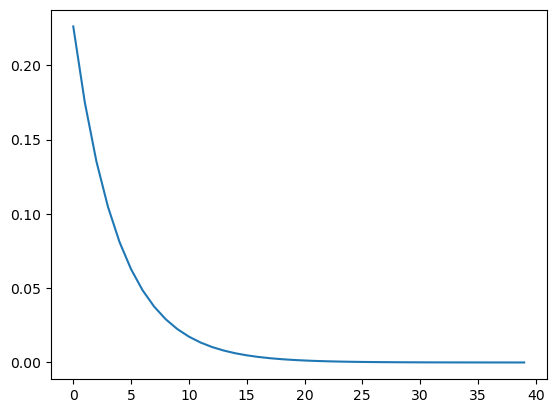

In [72]:
# plot the array
plt.plot(array)